In [ ]:
!pip install "dask[complete]"
!pip install pyarrow pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.9/83.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.6.4
    Uninstalling importlib-metadata-4.6.4:
      Successfully uninstalled importlib-metadata-4.6.4


In [ ]:
!pip install scikit-fuzzy
!pip install fuzzy-c-means

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 941.7 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894077 sha256=32a6c8fee622569eb4493cd08f80e6f328ca1c78d44f759eb76c9f698c80dbbd
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.5 MB/s eta 0:00:00
  Attempting uninstall: typer
    Found existing installation: typer 0.12.3
    Uninstalling typer-0.12.3:
      Successfully uninstalled typer-0.12.3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import dask.dataframe as dd
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
import numpy as np
import skfuzzy as fuzz

from warnings import filterwarnings
filterwarnings('ignore')



In [ ]:

# Directory containing the data files
data_dir = '/content/drive/MyDrive/Data_hasking'

# Get a list of all parquet files for the 10 days
file_list = sorted(glob.glob(f"{data_dir}/*.parquet"))[:10]  # Adjust the slicing if needed

# Load all parquet files into a Dask DataFrame
ddf = dd.read_parquet(file_list)

# Compute the DataFrame to get a Pandas DataFrame
df = ddf.compute()

In [ ]:

# Load customer data
tb_customers = dd.read_parquet('/content/drive/MyDrive/TB_CUSTOMERS.parquet')
tb_customers_df = tb_customers.compute()

In [ ]:
# Filter for individual customers
tb_customers_individual_df = tb_customers_df[tb_customers_df["CUSTOMER_TYPE"] == "Cá nhân"]
individual_customers = tb_customers_individual_df["CUST_CUSTNO"].unique().tolist()

In [ ]:
# Filter transactions for individual customers
df_individual = df[df['CUST_CUSTNO'].isin(individual_customers)]

In [ ]:
# Convert VALUEDATE to datetime
df_individual['VALUEDATE'] = pd.to_datetime(df_individual['VALUEDATE'], errors='coerce')

In [ ]:

# Extract date only from VALUEDATE
df_individual['DATE_ONLY'] = df_individual['VALUEDATE'].dt.date


In [ ]:
# Separate deposits (receipts) and withdrawals
df_deposits = df_individual[df_individual['AMOUNT'] > 0]
df_withdrawals = df_individual[df_individual['AMOUNT'] < 0]

In [ ]:
# Aggregate amounts by customer and date
daily_deposits = df_deposits.groupby(['CUST_CUSTNO', 'DATE_ONLY'])['AMOUNT'].sum().reset_index(name='total_deposits')
daily_withdrawals = df_withdrawals.groupby(['CUST_CUSTNO', 'DATE_ONLY'])['AMOUNT'].sum().reset_index(name='total_withdrawals')


In [ ]:
# Merge deposits and withdrawals
transactions = pd.merge(daily_deposits, daily_withdrawals, on=['CUST_CUSTNO', 'DATE_ONLY'], how='outer')


In [ ]:

# Fill missing values with 0
transactions['total_deposits'].fillna(0, inplace=True)
transactions['total_withdrawals'].fillna(0, inplace=True)

# Calculate the proportion of withdrawals to deposits
transactions['withdrawal_to_deposit_ratio'] = (transactions['total_withdrawals'].abs() / transactions['total_deposits']) * 100

**Implementing the Analysis and Visualization**

In [ ]:
# Log transform the total deposits and total withdrawals
transactions['log_total_deposits'] = np.log1p(transactions['total_deposits'])
transactions['log_total_withdrawals'] = np.log1p(transactions['total_withdrawals'].abs())

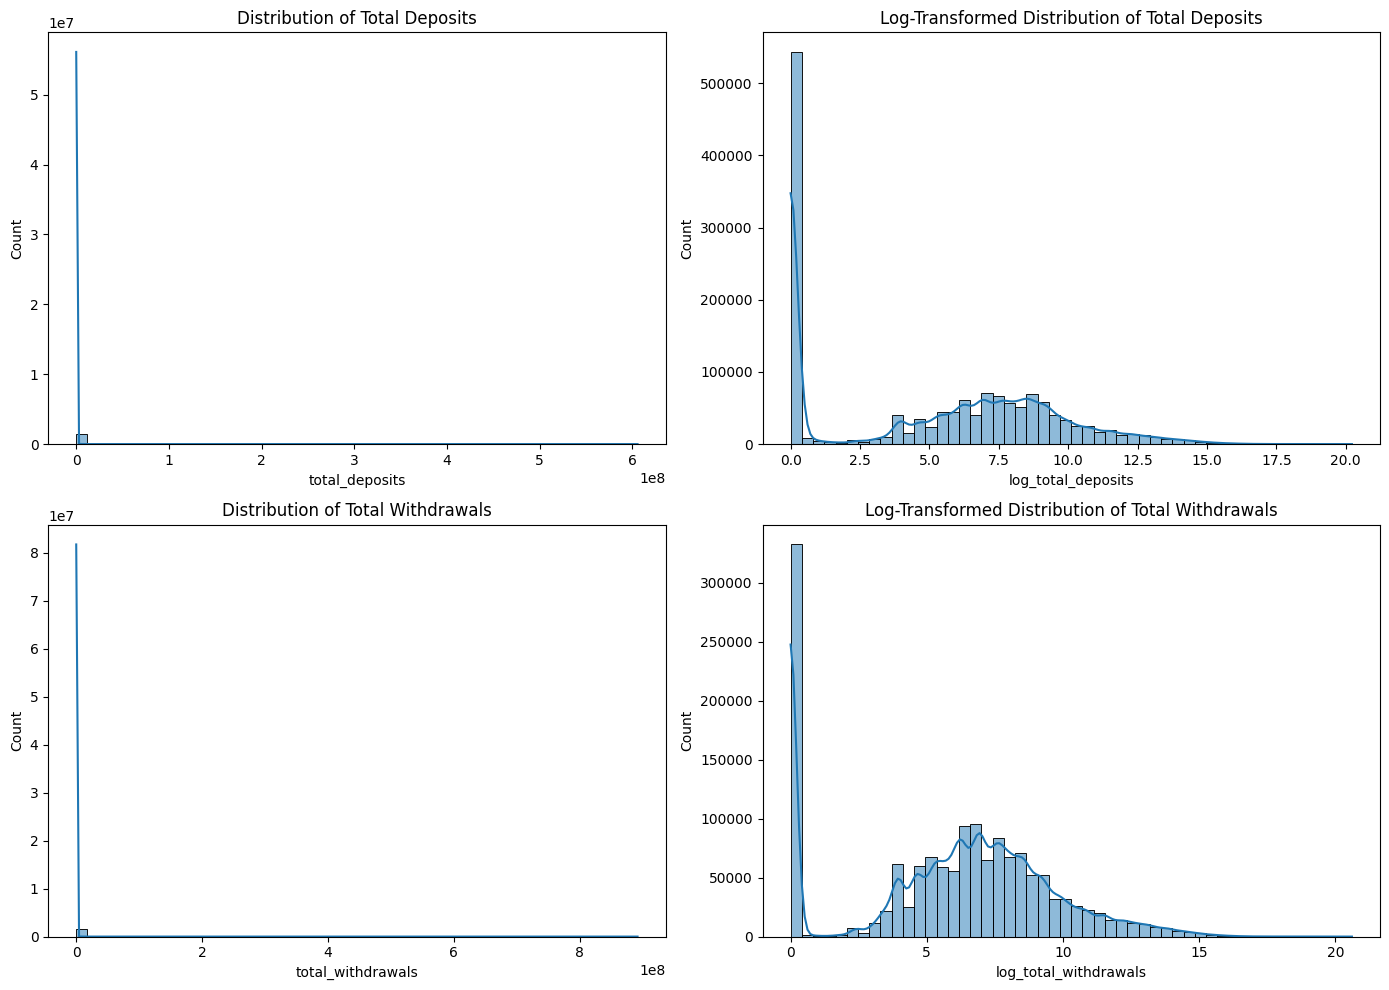

In [ ]:
# Plot the distributions before and after log transformation
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

sns.histplot(transactions['total_deposits'], bins=50, kde=True, ax=ax[0, 0])
ax[0, 0].set_title('Distribution of Total Deposits')

sns.histplot(transactions['log_total_deposits'], bins=50, kde=True, ax=ax[0, 1])
ax[0, 1].set_title('Log-Transformed Distribution of Total Deposits')

sns.histplot(transactions['total_withdrawals'].abs(), bins=50, kde=True, ax=ax[1, 0])
ax[1, 0].set_title('Distribution of Total Withdrawals')

sns.histplot(transactions['log_total_withdrawals'], bins=50, kde=True, ax=ax[1, 1])
ax[1, 1].set_title('Log-Transformed Distribution of Total Withdrawals')

plt.tight_layout()
plt.show()

**Steps for FCM Clustering**

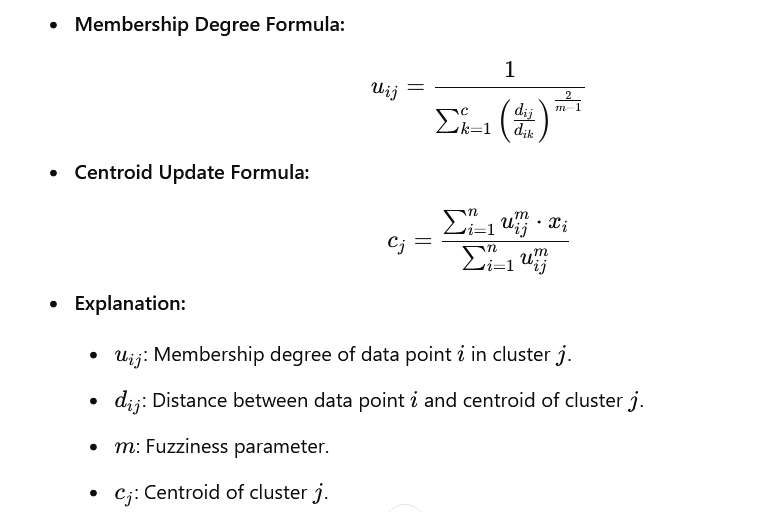

In [ ]:
# Prepare the data for clustering
features = transactions[['log_total_deposits', 'log_total_withdrawals']].values

In [ ]:
# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

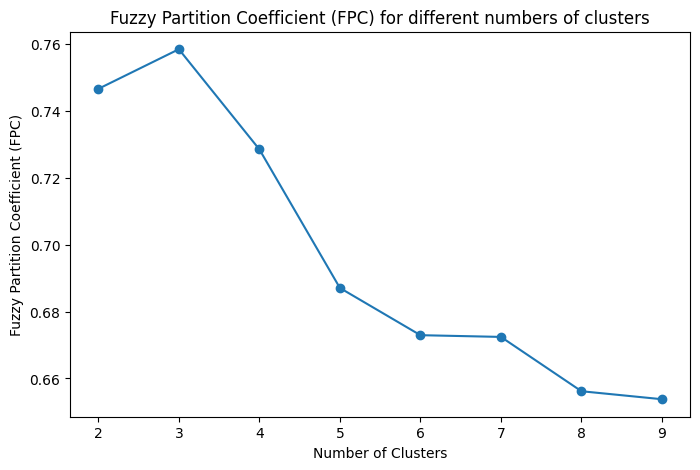

In [ ]:
# Define the range of clusters to evaluate
n_clusters_range = range(2, 10)
fpc_values = []

for n_clusters in n_clusters_range:
    # Apply Fuzzy C-Means clustering
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        features_scaled.T, c=n_clusters, m=2, error=0.005, maxiter=1000, init=None)

    # Store the FPC value for this number of clusters
    fpc_values.append(fpc)

# Plot FPC values to visualize the optimal number of clusters
plt.figure(figsize=(8, 5))
plt.plot(n_clusters_range, fpc_values, marker='o')
plt.title('Fuzzy Partition Coefficient (FPC) for different numbers of clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Fuzzy Partition Coefficient (FPC)')
plt.show()

In [ ]:
# Set the number of clusters
n_clusters = 3

In [ ]:
# Apply Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    features_scaled.T, c=n_clusters, m=2, error=0.005, maxiter=1000, init=None)

In [ ]:
# Assign clusters to each transaction based on the highest membership
cluster_labels = np.argmax(u, axis=0)


In [ ]:
# Add the cluster labels to the DataFrame
transactions['cluster'] = cluster_labels

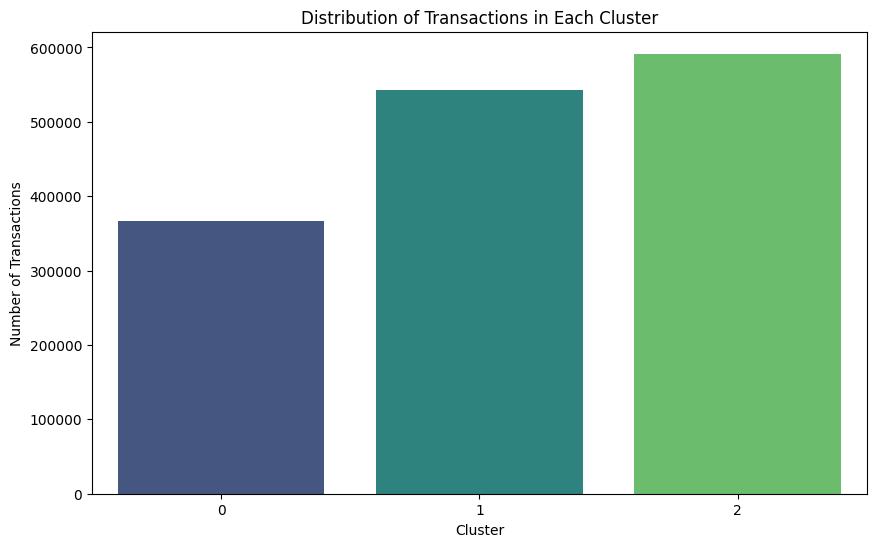

In [ ]:
# Visualize the distribution of transactions in each cluster
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', data=transactions, palette='viridis')
plt.title('Distribution of Transactions in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Transactions')
plt.show()


In [ ]:

# Count the number of transactions in each cluster
transactions['cluster'].value_counts()


cluster
2    591581
1    542448
0    366032
Name: count, dtype: int64

In [ ]:
# Calculate suspicion scores based on distance from the cluster centroid
suspicion_scores = np.min(d, axis=0)
transactions['suspicion_score'] = suspicion_scores

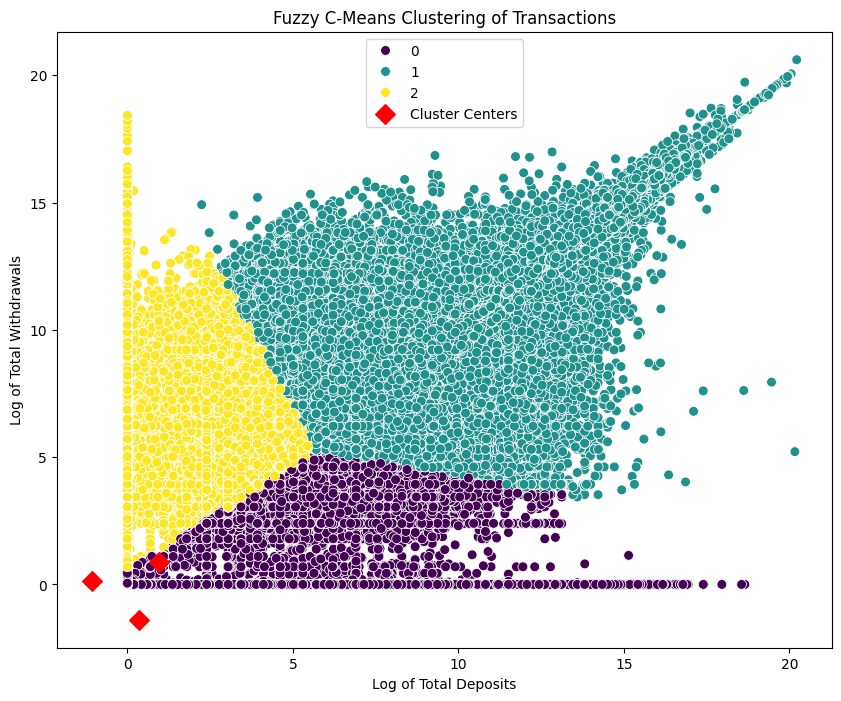

In [ ]:
# Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='log_total_deposits', y='log_total_withdrawals', hue='cluster', data=transactions, palette='viridis', s=50)
plt.scatter(cntr[:, 0], cntr[:, 1], marker='D', c='red', s=100, label='Cluster Centers')
plt.title('Fuzzy C-Means Clustering of Transactions')
plt.xlabel('Log of Total Deposits')
plt.ylabel('Log of Total Withdrawals')
plt.legend()
plt.show()


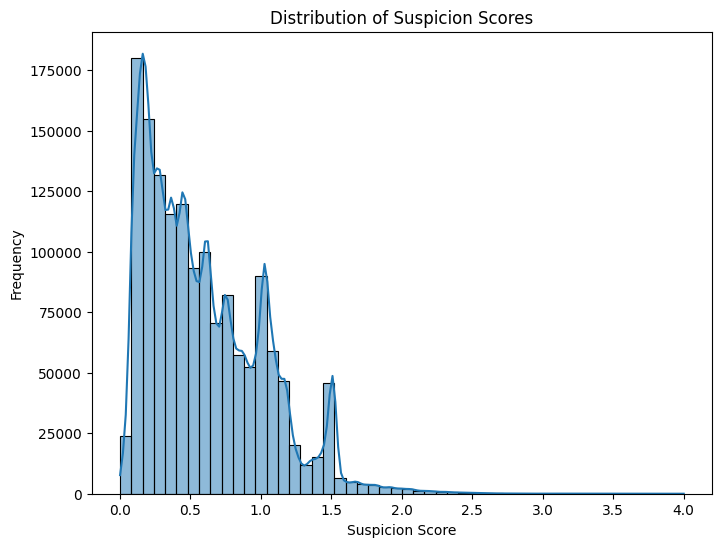

In [ ]:

# Plot the distribution of suspicion scores
plt.figure(figsize=(8, 6))
sns.histplot(transactions['suspicion_score'], bins=50, kde=True)
plt.title('Distribution of Suspicion Scores')
plt.xlabel('Suspicion Score')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Determine thresholds based on the distribution
threshold_high = transactions['suspicion_score'].quantile(0.90)
threshold_medium = transactions['suspicion_score'].quantile(0.75)

print(f"High suspicion threshold: {threshold_high}")
print(f"Medium suspicion threshold: {threshold_medium}")

High suspicion threshold: 1.158325910781597
Medium suspicion threshold: 0.8755387958970419


In [ ]:
# Classify transactions based on suspicion scores
def classify_transaction(score, low_threshold, high_threshold):
    if score >= high_threshold:
        return 'Fraudulent'
    elif score >= low_threshold:
        return 'Suspicious'
    else:
        return 'Normal'

# Apply classification
transactions['classification'] = transactions['suspicion_score'].apply(
    classify_transaction, args=(threshold_medium, threshold_high))

In [ ]:

# Display the classified transactions
classified_transactions = transactions[['CUST_CUSTNO', 'DATE_ONLY', 'total_deposits', 'total_withdrawals', 'suspicion_score', 'classification']]
print(classified_transactions.head())

                                         CUST_CUSTNO   DATE_ONLY  \
0  00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608...  2023-08-05   
1  00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608...  2023-08-10   
2  0000700d5e830cfa894850d424f1713b9290eb5dfd6be6...  2023-08-01   
3  0000700d5e830cfa894850d424f1713b9290eb5dfd6be6...  2023-08-02   
4  0000700d5e830cfa894850d424f1713b9290eb5dfd6be6...  2023-08-05   

   total_deposits  total_withdrawals  suspicion_score classification  
0         1500.00            -300.00         0.972181     Suspicious  
1        12717.60           -2063.00         0.383163         Normal  
2       400514.39         -701001.37         1.463642     Fraudulent  
3          524.00           -2734.00         0.720807         Normal  
4        10000.00          -10000.00         0.052135         Normal  


In [ ]:
# Apply Rule 15 conditions
rule_15_anomalies = transactions[
    (transactions['total_deposits'] >= 6000000) &
    (transactions['total_withdrawals'].abs() >= 0.95 * transactions['total_deposits'])
]


In [ ]:
# Compare with FCM-based classifications
comparison = pd.merge(classified_transactions, rule_15_anomalies,
                      on=['CUST_CUSTNO', 'DATE_ONLY', 'total_deposits', 'total_withdrawals'],
                      how='left', suffixes=('', '_rule15'))

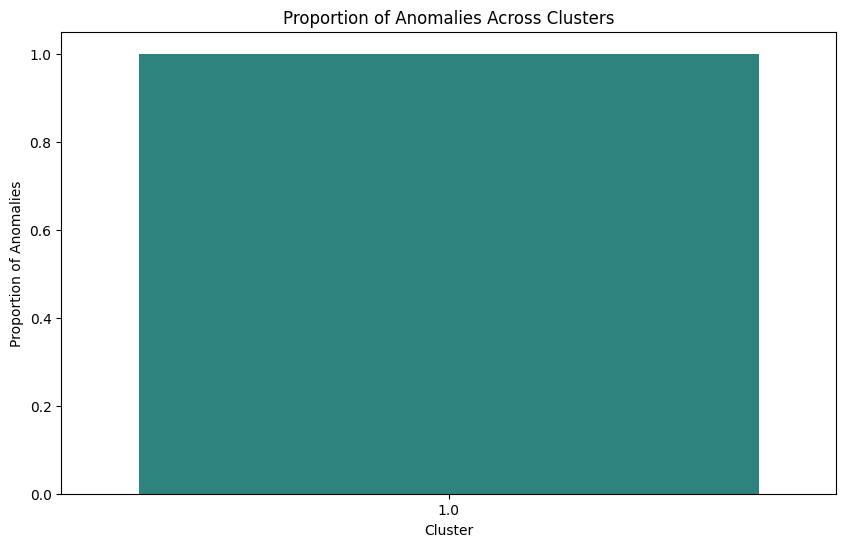

   cluster  anomaly_count  total_count  anomaly_proportion
0      1.0           1620         1620                 1.0


In [ ]:
# Add a column to indicate if a transaction is an anomaly according to Rule 15
comparison['is_rule15_anomaly'] = comparison['suspicion_score_rule15'].notna()

# Count the number of Rule 15 anomalies in each cluster
cluster_anomaly_distribution = comparison[comparison['is_rule15_anomaly']].groupby('cluster').size().reset_index(name='anomaly_count')

# Count the total number of transactions in each cluster
total_transactions_per_cluster = comparison.groupby('cluster').size().reset_index(name='total_count')

# Merge to get both counts in one DataFrame
cluster_distribution = pd.merge(cluster_anomaly_distribution, total_transactions_per_cluster, on='cluster')

# Calculate the proportion of anomalies in each cluster
cluster_distribution['anomaly_proportion'] = cluster_distribution['anomaly_count'] / cluster_distribution['total_count']

# Plot the distribution of anomalies across clusters
plt.figure(figsize=(10, 6))
sns.barplot(x='cluster', y='anomaly_proportion', data=cluster_distribution, palette='viridis')
plt.title('Proportion of Anomalies Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Proportion of Anomalies')
plt.show()

# Display the cluster distribution
print(cluster_distribution)


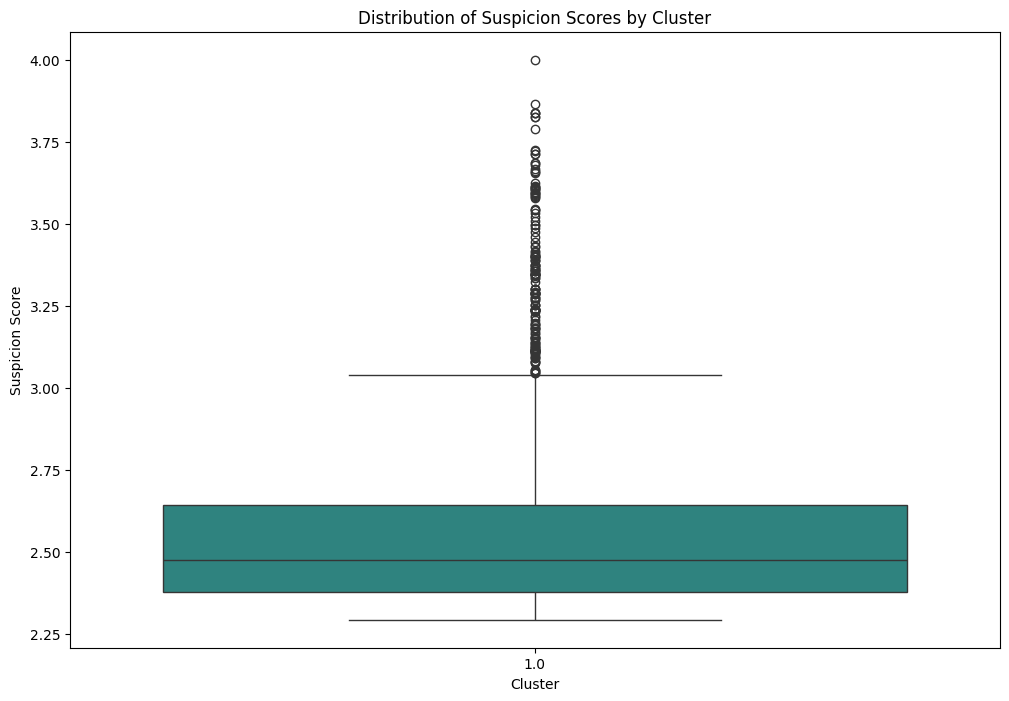

          count      mean       std       min       25%       50%     75%  \
cluster                                                                     
1.0      1620.0  2.582386  0.311608  2.293375  2.378486  2.476747  2.6436   

              max  
cluster            
1.0      4.000934  


In [ ]:
# Plot the distribution of suspicion scores by cluster
plt.figure(figsize=(12, 8))
sns.boxplot(x='cluster', y='suspicion_score', data=comparison, palette='viridis')
plt.title('Distribution of Suspicion Scores by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Suspicion Score')
plt.show()

# Summary statistics of suspicion scores by cluster
print(comparison.groupby('cluster')['suspicion_score'].describe())


In [ ]:
# prompt: evaluate the performance of your clustering method (FCM) in detecting anomalies, you can calculate the precision, recall, and F1 score.

# Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
true_positives = comparison[(comparison['classification'] == 'Fraudulent') & (comparison['is_rule15_anomaly'])].shape[0]
false_positives = comparison[(comparison['classification'] == 'Fraudulent') & (~comparison['is_rule15_anomaly'])].shape[0]
false_negatives = comparison[(comparison['classification'] != 'Fraudulent') & (comparison['is_rule15_anomaly'])].shape[0]

# Calculate precision, recall, and F1-score
if (true_positives + false_positives) == 0:
    precision = 0
else:
    precision = true_positives / (true_positives + false_positives)

if (true_positives + false_negatives) == 0:
    recall = 0
else:
    recall = true_positives / (true_positives + false_negatives)

if (precision + recall) == 0:
    f1_score = 0
else:
    f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision of the algorithm: {:.2f}".format(precision))
print("Recall of the algorithm: {:.2f}".format(recall))
print("F1-score of the algorithm: {:.2f}".format(f1_score))


Precision of the algorithm: 0.01
Recall of the algorithm: 1.00
F1-score of the algorithm: 0.02


In [ ]:
# Calculate True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN)
true_positives = comparison[(comparison['classification'] == 'Fraudulent') & (comparison['is_rule15_anomaly'])].shape[0]
false_positives = comparison[(comparison['classification'] == 'Fraudulent') & (~comparison['is_rule15_anomaly'])].shape[0]
true_negatives = comparison[(comparison['classification'] != 'Fraudulent') & (~comparison['is_rule15_anomaly'])].shape[0]
false_negatives = comparison[(comparison['classification'] != 'Fraudulent') & (comparison['is_rule15_anomaly'])].shape[0]

# Calculate accuracy
accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)

print("Accuracy of the algorithm: {:.2f}".format(accuracy))


Accuracy of the algorithm: 0.90


In [ ]:
# Analyze how many Rule 15 anomalies were classified as suspicious or fraudulent by FCM
rule_15_anomalies = comparison[comparison['suspicion_score_rule15'].notna()]

# Summary statistics
print("Summary statistics for Rule 15 anomalies:")
print(rule_15_anomalies[['suspicion_score', 'classification', 'suspicion_score_rule15', 'classification_rule15']].describe())

# Count of classifications
print("Count of classifications for Rule 15 anomalies:")
print(rule_15_anomalies['classification'].value_counts())
print(rule_15_anomalies['classification_rule15'].value_counts())


Summary statistics for Rule 15 anomalies:
       suspicion_score  suspicion_score_rule15
count      1620.000000             1620.000000
mean          2.582386                2.582386
std           0.311608                0.311608
min           2.293375                2.293375
25%           2.378486                2.378486
50%           2.476747                2.476747
75%           2.643600                2.643600
max           4.000934                4.000934
Count of classifications for Rule 15 anomalies:
classification
Fraudulent    1620
Name: count, dtype: int64
classification_rule15
Fraudulent    1620
Name: count, dtype: int64


In [ ]:
# Filter for transactions that are both Rule 15 anomalies and classified as suspicious or fraudulent by FCM
overlapping_anomalies = comparison[
    (comparison['is_rule15_anomaly']) &
    (comparison['classification'].isin(['Suspicious', 'Fraudulent']))
]

# Display the overlapping anomalies
overlapping_anomalies[['CUST_CUSTNO', 'DATE_ONLY', 'total_deposits', 'total_withdrawals', 'suspicion_score', 'classification']]


,CUST_CUSTNO,DATE_ONLY,total_deposits,total_withdrawals,suspicion_score,classification
978,003e0235aab29e1788ce064113f24f8703921030065318...,2023-08-07,11236003.08,-12497903.80,2.542920,Fraudulent
1353,00527a90ea8ac7e0cb02edb41f08ec69cacd447c1e06a3...,2023-08-03,7162326.10,-7162163.01,2.363438,Fraudulent
1355,00527a90ea8ac7e0cb02edb41f08ec69cacd447c1e06a3...,2023-08-07,6172231.88,-6342641.09,2.316527,Fraudulent
2030,008305ae484962df097f666beadd0aaf025cfbc520151c...,2023-08-04,8561497.60,-8561400.01,2.426186,Fraudulent
2248,008ebd410e08ed2eaa6c7d5d525c3761630b696af313f8...,2023-08-08,15536751.83,-15296750.89,2.632657,Fraudulent
...,...,...,...,...,...,...
998320,ff8d7492d6aa39bc6177141f150c866919549060c062e2...,2023-08-04,15698000.00,-15683291.00,2.639183,Fraudulent
998323,ff8d7492d6aa39bc6177141f150c866919549060c062e2...,2023-08-08,8450516.00,-8359730.00,2.419462,Fraudulent
998324,ff8d7492d6aa39bc6177141f150c866919549060c062e2...,2023-08-09,12835000.00,-12719050.00,2.566768,Fraudulent
998578,ff9f2b5ccdfe4e76cb65ea25e5a9819004960b989c40d9...,2023-08-03,8211287.25,-8230508.91,2.411965,Fraudulent


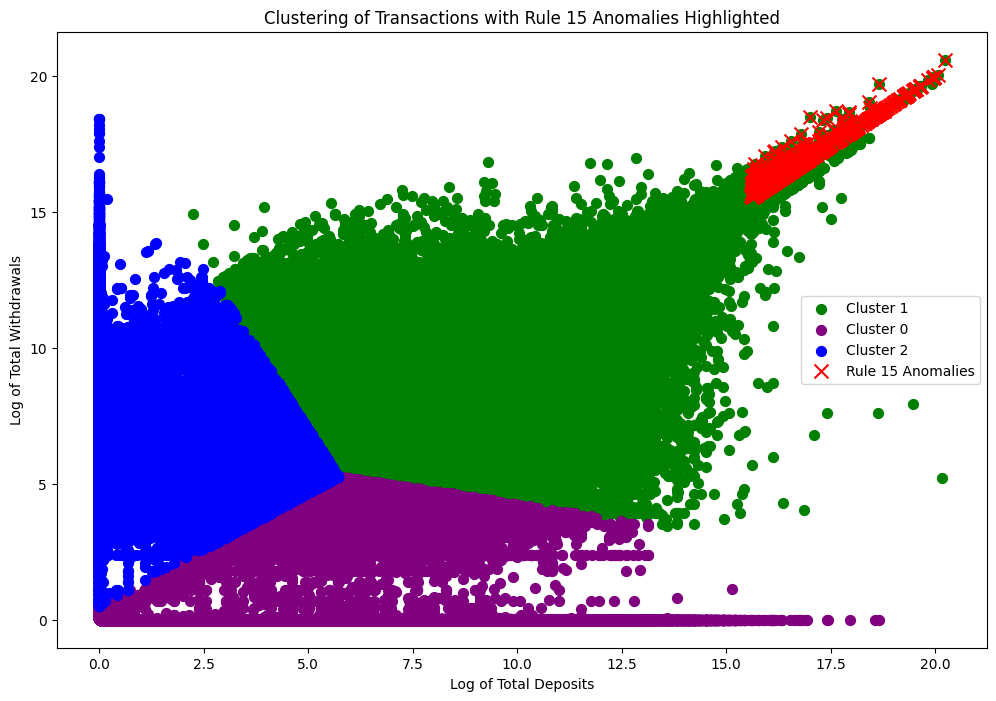

In [ ]:

# Plot the clusters with Rule 15 anomalies highlighted
plt.figure(figsize=(12, 8))
colors = {0: 'purple', 1: 'green', 2: 'blue'}

for cluster in transactions['cluster'].unique():
    cluster_data = transactions[transactions['cluster'] == cluster]
    plt.scatter(cluster_data['log_total_deposits'], cluster_data['log_total_withdrawals'],
                c=colors[cluster], label=f'Cluster {cluster}', s=50)

# Highlight Rule 15 anomalies
rule_15_anomalies = transactions[
    (transactions['total_deposits'] >= 6000000) &
    (transactions['total_withdrawals'].abs() >= 0.95 * transactions['total_deposits'])
]
plt.scatter(rule_15_anomalies['log_total_deposits'], rule_15_anomalies['log_total_withdrawals'],
            c='red', marker='x', s=100, label='Rule 15 Anomalies')

plt.title('Clustering of Transactions with Rule 15 Anomalies Highlighted')
plt.xlabel('Log of Total Deposits')
plt.ylabel('Log of Total Withdrawals')
plt.legend()
plt.show()
